In [34]:
import pandas as pd
!pip install detoxify
from detoxify import Detoxify
import spacy
from spacy import displacy
from semeval2021 import f1
from semeval2021 import evaluate

In [16]:
comments = pd.read_csv('data/tsd_train.csv')
comments.head(10)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA..."
5,[],"But, but, but, is NOT a defense. It's not eve..."
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","Please people, stop using these silly, stupid ..."
7,"[0, 1, 2, 3]",Dumb.
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",Obamacare is on it's last gasping breaths. Y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",CROOKED Trump = GUILTY as hell.\npathetic


In [17]:
# Lower case all the words
comments['cleaned_text'] = comments['text'].apply(lambda x: x.lower())
comments.head(10)

,spans,text,cleaned_text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...,another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio...","i am 56 years old, i am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed.","damn, a whole family. sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...,what a knucklehead. how can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA...","""who do you think should do the killing?""\n\na..."
5,[],"But, but, but, is NOT a defense. It's not eve...","but, but, but, is not a defense. it's not eve..."
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","Please people, stop using these silly, stupid ...","please people, stop using these silly, stupid ..."
7,"[0, 1, 2, 3]",Dumb.,dumb.
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",Obamacare is on it's last gasping breaths. Y...,obamacare is on it's last gasping breaths. y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",CROOKED Trump = GUILTY as hell.\npathetic,crooked trump = guilty as hell.\npathetic


### Classifier

toxicBERT

In [18]:
print(comments.text[0])
print(comments.text[0].split())
print(comments.spans[0])

Another violent and aggressive immigrant killing a innocent and intelligent US Citizen.... Sarcasm
['Another', 'violent', 'and', 'aggressive', 'immigrant', 'killing', 'a', 'innocent', 'and', 'intelligent', 'US', 'Citizen....', 'Sarcasm']
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


### Using spacy to tokenize the words

In [19]:
!spacy download en_core_web_sm
sp = spacy.load('en_core_web_sm')

# Import pre-trained toxicBERT model from Huggingface
unbiased_model = Detoxify('unbiased', device='cuda')

     |████████████████████████████████| 12.0 MB 15.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [21]:
def get_span_predicated(index, text):
    sentence_content = sp(text)
    text_words = []
    for token in sentence_content:
        if token.pos_ != 'PUNCT':
            text_words.append(str(token.text))

    toxic_prediction = unbiased_model.predict(text_words)

    span_predicted = '['
    span = []
    for i in range(0, len(toxic_prediction['toxicity'])):
        if toxic_prediction['toxicity'][i] > 0.8:
            cur = text.find(text_words[i])
            for j in range(0, len(text_words[i])):
                span.append(str(cur))
                cur += 1
    span_predicted += ', '.join(span)
    span_predicted += ']'

    return span_predicted

spans_predicted = []
for index, row in comments.iterrows():
    spans_predicted.append(get_span_predicated(int(index), row['cleaned_text']))

comments['spans_predicted'] = spans_predicted
comments.head(10)

,spans,text,cleaned_text,spans_predicted
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...,another violent and aggressive immigrant killi...,[]
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio...","i am 56 years old, i am not your fucking junio...","[33, 34, 35, 36, 37, 38, 39, 154, 155, 156, 157]"
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed.","damn, a whole family. sad indeed.","[0, 1, 2, 3]"
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...,what a knucklehead. how can anyone not know th...,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]"
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA...","""who do you think should do the killing?""\n\na...","[626, 627, 628, 629, 630, 32, 33, 34, 35, 32, ..."
5,[],"But, but, but, is NOT a defense. It's not eve...","but, but, but, is not a defense. it's not eve...","[278, 279, 280, 281, 282, 283, 284]"
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","Please people, stop using these silly, stupid ...","please people, stop using these silly, stupid ...","[32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44]"
7,"[0, 1, 2, 3]",Dumb.,dumb.,"[0, 1, 2, 3]"
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",Obamacare is on it's last gasping breaths. Y...,obamacare is on it's last gasping breaths. y...,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1..."
9,"[32, 33, 34, 35, 36, 37, 38, 39]",CROOKED Trump = GUILTY as hell.\npathetic,crooked trump = guilty as hell.\npathetic,"[32, 33, 34, 35, 36, 37, 38, 39]"


In [23]:
comments["f1_scores"] = comments.apply(lambda row: f1(row.spans_predicted, row.spans), axis=1)
comments.head(10)

,spans,text,cleaned_text,spans_predicted,f1_scores
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...,another violent and aggressive immigrant killi...,[],0.250000
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio...","i am 56 years old, i am not your fucking junio...","[33, 34, 35, 36, 37, 38, 39, 154, 155, 156, 157]",0.956522
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed.","damn, a whole family. sad indeed.","[0, 1, 2, 3]",1.000000
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...,what a knucklehead. how can anyone not know th...,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",1.000000
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA...","""who do you think should do the killing?""\n\na...","[626, 627, 628, 629, 630, 32, 33, 34, 35, 32, ...",0.916667
5,[],"But, but, but, is NOT a defense. It's not eve...","but, but, but, is not a defense. it's not eve...","[278, 279, 280, 281, 282, 283, 284]",0.285714
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","Please people, stop using these silly, stupid ...","please people, stop using these silly, stupid ...","[32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44]",0.923077
7,"[0, 1, 2, 3]",Dumb.,dumb.,"[0, 1, 2, 3]",1.000000
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",Obamacare is on it's last gasping breaths. Y...,obamacare is on it's last gasping breaths. y...,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",1.000000
9,"[32, 33, 34, 35, 36, 37, 38, 39]",CROOKED Trump = GUILTY as hell.\npathetic,crooked trump = guilty as hell.\npathetic,"[32, 33, 34, 35, 36, 37, 38, 39]",1.000000


F1 = 0.81 ± 0.00


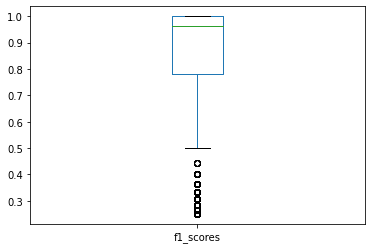

In [25]:
from scipy.stats import sem
_ = comments.f1_scores.plot(kind="box")
print (f"F1 = {comments.f1_scores.mean():.2f} ± {sem(comments.f1_scores):.2f}")

In [28]:
# make sure that the ids match the ones of the scores
predictions = comments.spans_predicted.to_list()
ids = comments.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-pred.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head spans-pred.txt

0	[]
1	[33, 34, 35, 36, 37, 38, 39, 154, 155, 156, 157]
2	[0, 1, 2, 3]
3	[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
4	[626, 627, 628, 629, 630, 32, 33, 34, 35, 32, 33, 34, 35]
5	[278, 279, 280, 281, 282, 283, 284]
6	[32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44]
7	[0, 1, 2, 3]
8	[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 151, 152]
9	[32, 33, 34, 35, 36, 37, 38, 39]


In [33]:
gold = comments.spans.to_list()
ids = comments.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-gold.txt", "w") as out:
  for uid, text_scores in zip(ids, gold):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head spans-gold.txt


0	[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
1	[33, 34, 35, 36, 37, 38, 39]
2	[0, 1, 2, 3]
3	[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
4	[32, 33, 34, 35, 36, 37, 38]
5	[]
6	[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54]
7	[0, 1, 2, 3]
8	[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 151, 152]
9	[32, 33, 34, 35, 36, 37, 38, 39]


# Evaluation

In [35]:
predictions = open("spans-pred.txt", "r")
gold = open("spans-gold.txt", "r")

score = evaluate(predictions, gold)
print(score)

(0.5801767871689368, 0.004636474150721709)
